In [1]:
# The idea is to use nWindows (say 3), and look at dependency upon sorting by window_mean.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

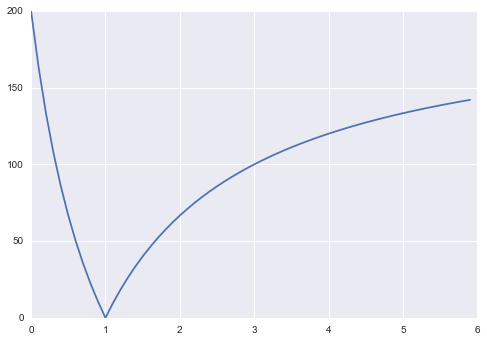

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [8]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

(65118, 3)
(65118, 3)


C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


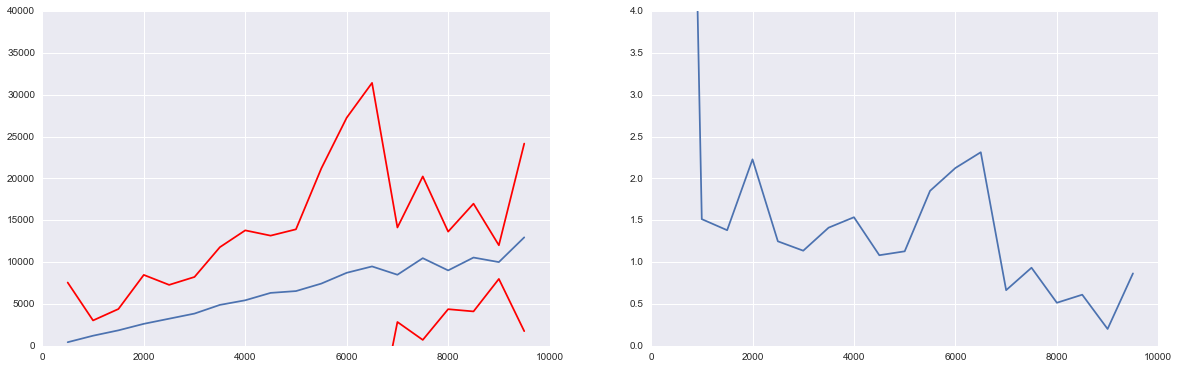

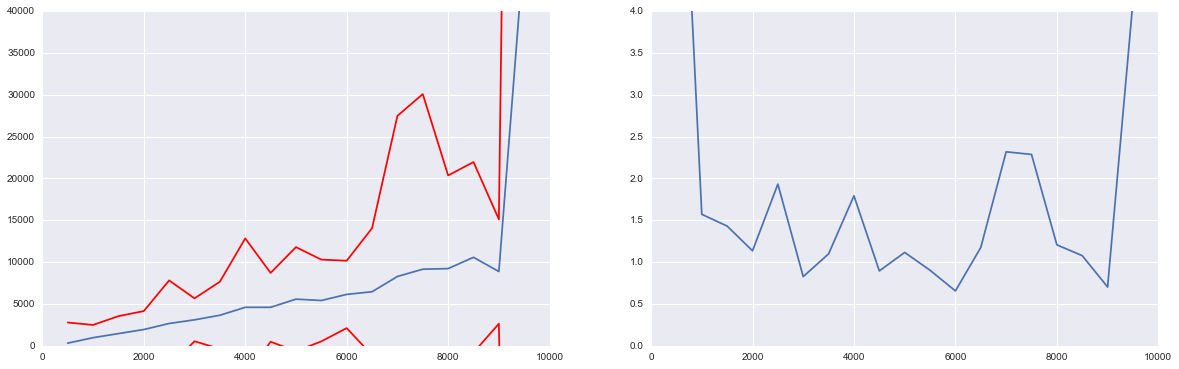

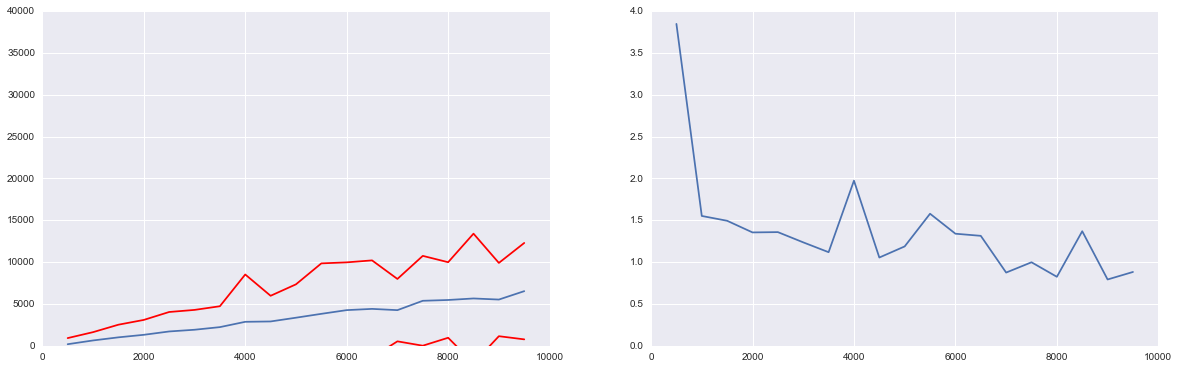

In [9]:
# Let's try sorting the window means.

epsilon = 1e-4
Y_mean = Y_train.mean(axis = 1, keepdims = True)
nSamples, nTimes = X_train.shape
size = 150
nWindows = 3
window_means = np.empty((nSamples, 0))

for i in range(nWindows):
    newCol = X_train[:, nTimes - 1 - (i+1) * size : nTimes - 1 - i * size].mean(axis = 1, keepdims = True)
    window_means = np.hstack((window_means, newCol))
    
print(window_means.shape)
sorted_means = np.sort(window_means)
print(sorted_means.shape)

width = 1e4
bins = np.arange(0, width, width / 20)
for i in range(nWindows):
    binsInd = np.digitize(sorted_means[:,i], bins)
    means = [Y_mean[binsInd == i].mean() for i in range(len(bins))]
    stds = [Y_mean[binsInd == i].std() for i in range(len(bins))]
    means, stds = np.array(means), np.array(stds)

    plt.figure(figsize = (20, 6))
    plt.subplot(121)
    plt.plot(bins, means)
    plt.plot(bins, means + stds, color = 'red')
    plt.plot(bins, means - stds, color = 'red')
    ax = plt.gca()
    ax.set_ylim([0, 4e4])
    
    plt.subplot(122)
    plt.plot(bins, stds / (epsilon + means))
    ax = plt.gca()
    ax.set_ylim([0, 4])
    plt.show()

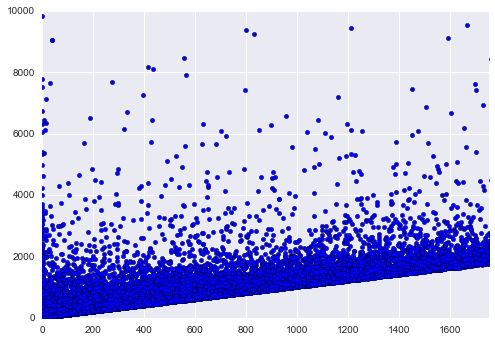

Count of min < 1.75e3 and middle > 1.75e3 =  1824 	Percent nextLevelMask =  0.0300662644644
Count of lastLevelMask =  4964 	Percent lastLevelMask =  0.0818250750008


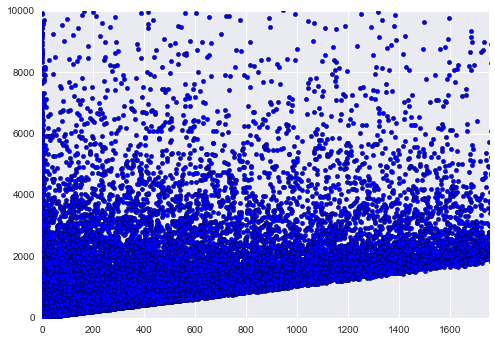

In [10]:
# Ratio of std to mean seems good for values > 1.75e3 in all cases. So let's check if minimum is below this, then when is
# next levels above 1.75e3.

plt.scatter(sorted_means[:,0], sorted_means[:,1] )
ax = plt.gca()
ax.set_xlim([0, 1.75e3])
ax.set_ylim([0, 1e4])
plt.show()
lowLevelFailMask = sorted_means[:, 0] < 1.75e3
nextLevelMask = (lowLevelFailMask & (sorted_means[:,1] > 1.75e3))
lastLevelMask = (lowLevelFailMask & (sorted_means[:,1] < 1.75e3) & (sorted_means[:,2] > 1.75e3))
print('Count of min < 1.75e3 and middle > 1.75e3 = ', np.sum(nextLevelMask), '\tPercent nextLevelMask = ',
      np.sum(nextLevelMask) / np.sum(lowLevelFailMask))
print('Count of lastLevelMask = ', np.sum(lastLevelMask), '\tPercent lastLevelMask = ',
      np.sum(lastLevelMask) / np.sum(lowLevelFailMask))

plt.scatter(sorted_means[:,0], sorted_means[:,2] )
ax = plt.gca()
ax.set_xlim([0, 1.75e3])
ax.set_ylim([0, 1e4])
plt.show()

In [11]:
def window_means(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    means = np.empty((nSamples, 0))
    for i in range(nWindows):
        newCol = X[:, nTimes - 1 - (i+1) * windowSize : nTimes - 1 - i * windowSize].mean(axis = 1, keepdims = True)
        means = np.hstack((means, newCol))
    return means

def sorted_mask_means(X, nWindows = 3, windowSize = 150, cuts = 1.75e3):
    nSamples, nTimes = X.shape
    means = window_means(X, nWindows, windowSize)
    sorted_means = np.sort(means)
    fitVarMask = np.empty((nSamples,0), dtype = 'bool')
    for i in range(nWindows - 1):
        newMask = sorted_means[:,i] > cuts
        for j in range(i):
            newMask = newMask & (~fitVarMask[:,j])
        fitVarMask = np.hstack((fitVarMask, newMask.reshape(-1,1)))
    
    # Last column is just everything that wasn't processed before.
    newMask = np.full(nSamples, True, dtype = 'bool')
    for i in range(nWindows - 1):
        newMask = newMask & (~fitVarMask[:, i])
    fitVarMask = np.hstack((fitVarMask, newMask.reshape(-1,1)))
                               
    return fitVarMask, sorted_means

In [12]:
# Let's do a simple test of linear fit on lowest level > 1.75e3, middle level > 1.75e3, and the finally fit on highest level.

nWindows = 3
cuts = 0.3e3
mask_trainvalid, sorted_trainvalid = sorted_mask_means(X_train, cuts = cuts)
mask_test, sorted_test = sorted_mask_means(X_valid, cuts = cuts)

Y_predict = np.zeros(Y_valid.shape)
for i in range(nWindows):
    mask = mask_trainvalid[:, i]
    X_level = sorted_trainvalid[mask, i].reshape(-1,1)
    Y_level = Y_train[mask, :]
    model = LinearRegression()
    model.fit(X_level, Y_level)
    
    mask = mask_test[:, i]
    X_leveltest = sorted_test[mask, i].reshape(-1,1)
    Y_predict[mask,:] = model.predict(X_leveltest)

print('Smape score = ', smape(Y_predict, Y_valid))
print('Count Y_predict == 0 is ', np.sum(Y_predict == 0), '\tY_predict.shape = ', Y_predict.shape)

Smape score =  118.936166368
Count Y_predict == 0 is  0 	Y_predict.shape =  (32074, 64)


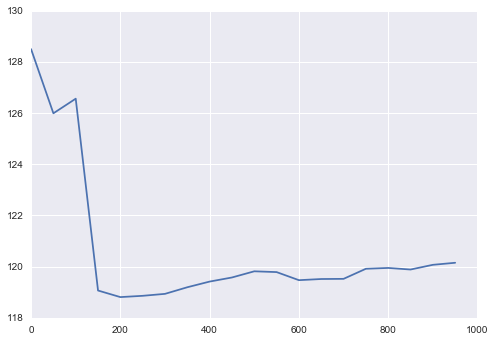

In [13]:
# Let's vary cuts.

nWindows = 3
cuts_search = np.arange(0.0, 1.0e3, 0.05e3)

smapes = []
for cuts in cuts_search:
    mask_trainvalid, sorted_trainvalid = sorted_mask_means(X_train, cuts = cuts)
    mask_test, sorted_test = sorted_mask_means(X_valid, cuts = cuts)

    Y_predict = np.zeros(Y_valid.shape)
    for i in range(nWindows):
        mask = mask_trainvalid[:, i]
        X_level = sorted_trainvalid[mask, i].reshape(-1,1)
        Y_level = Y_train[mask, :]
        model = LinearRegression()
        model.fit(X_level, Y_level)
    
        mask = mask_test[:, i]
        X_leveltest = sorted_test[mask, i].reshape(-1,1)
        Y_predict[mask,:] = model.predict(X_leveltest)
    smapes.append(smape(Y_predict, Y_valid))

plt.plot(cuts_search, smapes)
plt.show()

In [14]:
# Let's do a simple test of linear fit on lowest level > 1.75e3, middle level > 1.75e3, and the finally fit on highest level.

nWindows = 3
cuts = 0.2e3
mask_trainvalid, sorted_trainvalid = sorted_mask_means(X_trainvalid, cuts = cuts)
mask_test, sorted_test = sorted_mask_means(X_test, cuts = cuts)

Y_predict = np.zeros(Y_test.shape)
for i in range(nWindows):
    mask = mask_trainvalid[:, i]
    X_level = sorted_trainvalid[mask, i].reshape(-1,1)
    Y_level = Y_trainvalid[mask, :]
    model = LinearRegression()
    model.fit(X_level, Y_level)
    
    mask = mask_test[:, i]
    X_leveltest = sorted_test[mask, i].reshape(-1,1)
    Y_predict[mask,:] = model.predict(X_leveltest)

print('Smape score = ', smape(Y_predict, Y_test))
print('Count Y_predict == 0 is ', np.sum(Y_predict == 0), '\tY_predict.shape = ', Y_predict.shape)

Smape score =  115.306469585
Count Y_predict == 0 is  0 	Y_predict.shape =  (47871, 64)


In [15]:
# As a benchmark, let's just get a linear fit of overall mean.

model = Pipeline([ ('all_mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', LinearRegression()) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('Smape score = ', smape(Y_predict, Y_test))

Smape score =  117.577692786


Smape score =  109.585760287
1 , 4 , 7 , 10 , 13 , 8 , 9 , 10 , 11 , 12 , 13 , 

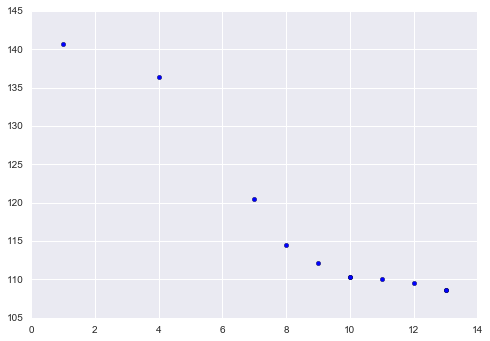

In [16]:
# Now let's try a decision tree on the sorted means.

model = Pipeline([ ('means', FunctionTransformer(window_means, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('sorted', FunctionTransformer(lambda X : np.sort(X))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('Smape score = ', smape(Y_valid, Y_predict))

# Let's try different levels of depth.

depths = np.arange(1, 15, 3)
depths = np.hstack((depths, np.arange(8, 14, 1)))
search_scores = []
for depth in depths:
    model.set_params(tree__max_depth = depth)
    scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
    search_scores.append(scores.mean())
    print(depth, ', ', end = '')
    
plt.scatter(depths, search_scores)
plt.show()

Smape score =  110.590506228


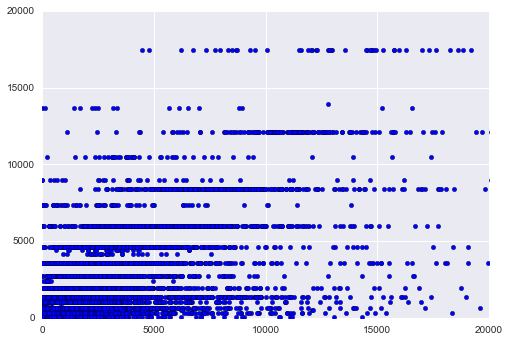

In [17]:
# Let's test model with max_depth = 10.
model = Pipeline([ ('means', FunctionTransformer(window_means, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('sorted', FunctionTransformer(lambda X : np.sort(X))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('Smape score = ', smape(Y_test, Y_predict))

plt.scatter(Y_test.mean(axis = 1), Y_predict.mean(axis = 1))
ax = plt.gca()
ax.set_xlim([0, 2e4])
ax.set_ylim([0, 2e4])
plt.show()

In [21]:
# Let's try Decision Tree on transformed Y.

def Ztransform(Y, param):
    return np.log(param + Y)

def invZtransform(Z, param):
    return -param + np.exp(Z)

model = Pipeline([ ('means', FunctionTransformer(window_means, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('sorted', FunctionTransformer(lambda X : np.sort(X))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
Z_trainvalid = Ztransform(Y_trainvalid, param = 15)
Z_test = Ztransform(Y_test, param = 15)
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = invZtransform(Z_predict, param = 15)
print('smape = ', smape(Y_predict, Y_test))

smape =  83.4999692713


param =  1 	Smape =  84.955344851param =  3 	Smape =  84.5481267379param =  5 	Smape =  84.4154167015param =  7 	Smape =  84.4395009933param =  9 	Smape =  84.4862198496param =  11 	Smape =  84.3807542234param =  13 	Smape =  84.3199420125param =  15 	Smape =  84.3663360379param =  17 	Smape =  84.2646153942param =  19 	Smape =  84.2488412416param =  21 	Smape =  84.3566718873param =  23 	Smape =  84.3757974931param =  25 	Smape =  84.4631422473param =  27 	Smape =  84.5089710218param =  29 	Smape =  84.4067450584param =  31 	Smape =  84.3456177146param =  33 	Smape =  84.3774693716param =  35 	Smape =  84.4080598846param =  37 	Smape =  84.4848832932param =  39 	Smape =  84.5287173179

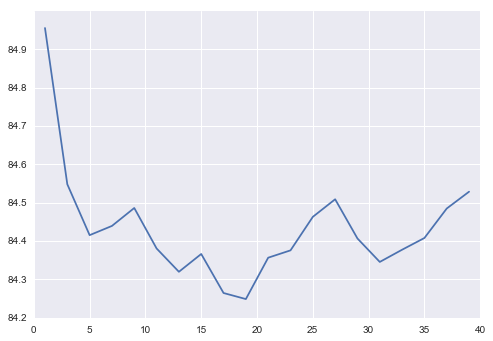

In [23]:
# Let's do transform parameter search to be sure.

param_search = np.arange(1, 40, 2)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

In [27]:
# Let's try Decision Tree on transformed Y.

def Ztransform(Y, param):
    return 1 / (param + Y)

def invZtransform(Z, param ):
    return -param + 1 / Z

model = Pipeline([ ('means', FunctionTransformer(window_means, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('sorted', FunctionTransformer(lambda X : np.sort(X))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
Z_trainvalid = Ztransform(Y_trainvalid, param = 100)
Z_test = Ztransform(Y_test, param = 100)
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = invZtransform(Z_predict, param = 100)
print('smape = ', smape(1e-4+Y_predict, Y_test))

smape =  85.0786029811


param =  1 	Smape =  94.332623254param =  11 	Smape =  88.302033489param =  21 	Smape =  87.3849408118param =  31 	Smape =  86.8671739829param =  41 	Smape =  86.4966175001param =  51 	Smape =  86.2549795317param =  61 	Smape =  86.0869583996param =  71 	Smape =  86.0378372475param =  81 	Smape =  85.8384484037param =  91 	Smape =  85.7647357731param =  101 	Smape =  85.6443927335param =  111 	Smape =  85.695877464param =  121 	Smape =  85.667507091param =  131 	Smape =  85.5235522975param =  141 	Smape =  85.5598966568param =  151 	Smape =  85.5172770496param =  161 	Smape =  85.5508241057param =  171 	Smape =  85.588379136param =  181 	Smape =  85.6128623724param =  191 	Smape =  85.8469244137

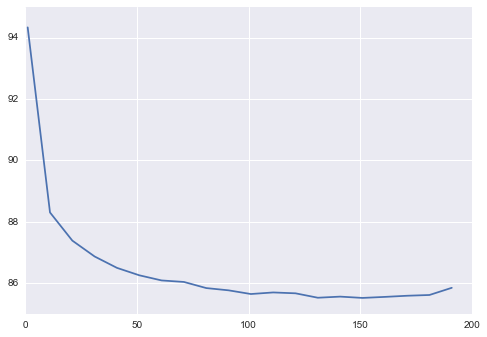

In [26]:
# Let's do transform parameter search to be sure.

param_search = np.arange(1, 200, 10)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()